In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import find_peaks
from sklearn.metrics import mutual_info_score
from matplotlib.pyplot import figure
import matplotlib
import seaborn as sns
from matplotlib.lines import Line2D
from funcs import getStatsMetrics, getHistSignalPlot, getSpikesPlot

matplotlib.rc('figure', figsize=(18, 4))

# Carga de Datos del archivo Control 

In [14]:
data = pd.read_csv('TrozoC.txt', delimiter='\t', header=None, skiprows = range(3), decimal = ",", index_col = False)

In [15]:
data.head()

,0,1,2
0,0.004883,0.015259,NaN
1,0.001526,0.024109,NaN
2,-0.010681,0.031128,NaN
3,-0.022278,0.041809,NaN
4,-0.028076,0.045471,NaN


In [16]:
print(len(data))
data.drop(columns=[2], inplace=True)
data.columns = ['LP','VD']
data = data.apply(pd.to_numeric)
data['Time'] = data.index
print(data.head())

19847700
         LP        VD  Time
0  0.004883  0.015259     0
1  0.001526  0.024109     1
2 -0.010681  0.031128     2
3 -0.022278  0.041809     3
4 -0.028076  0.045471     4


In [17]:
data.dropna(axis=0, how='any',inplace=True)
data.isnull().sum()

LP      0
VD      0
Time    0
dtype: int64

In [18]:
data.describe()

,LP,VD,Time
count,1.984770e+07,1.984770e+07,1.984770e+07
mean,-2.253853e-08,4.385849e-02,9.923850e+06
std,8.214042e-02,3.287948e-02,5.729538e+06
min,-7.101440e-01,-2.170715e+00,0.000000e+00
25%,-2.288800e-02,3.295900e-02,4.961925e+06
50%,3.050000e-04,4.364000e-02,9.923850e+06
75%,2.410900e-02,5.401600e-02,1.488577e+07
max,9.344480e-01,1.351624e+00,1.984770e+07


# Cálculo de umbrales

In [19]:
dist_sd = 2
lp_mean,lp_sd,low_lp,high_lp = getStatsMetrics(data.LP, dist_sd)
print('LP:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(lp_mean,lp_sd,low_lp,high_lp))

vd_mean,vd_sd,low_vd,high_vd = getStatsMetrics(data.VD, dist_sd)
print('VD:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(vd_mean,vd_sd,low_vd,high_vd))

LP:
	Mean: -0.000000
	SD: 0.082140
	Low: -0.164281
	High: 0.164281
VD:
	Mean: 0.043858
	SD: 0.032879
	Low: -0.021900
	High: 0.109617


# Visualización del histograma de la señal y los umbrales escogidos

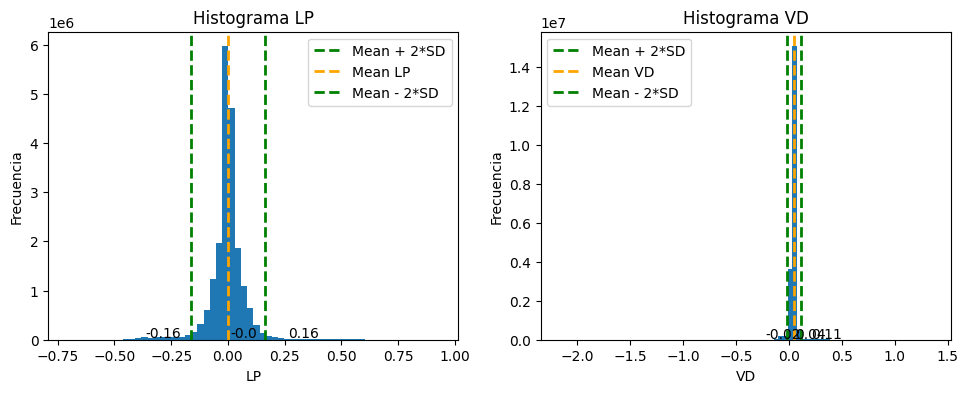

In [20]:
plt.subplot(1,3,1)
getHistSignalPlot(data.LP,lp_mean,low_lp,high_lp, dist_sd, 'LP', bins=60, umb = 'both')

plt.subplot(1,3,2)
getHistSignalPlot(data.VD,vd_mean,low_vd,high_vd, dist_sd, 'VD', bins=80, umb = 'both')

In [21]:
data.head()

,LP,VD,Time
0,0.004883,0.015259,0
1,0.001526,0.024109,1
2,-0.010681,0.031128,2
3,-0.022278,0.041809,3
4,-0.028076,0.045471,4


# Visualización de los codificación SAX en la señal

C:\Users\marlo\AppData\Local\Temp\ipykernel_14212\1267551047.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]
C:\Users\marlo\AppData\Local\Temp\ipykernel_14212\1267551047.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]


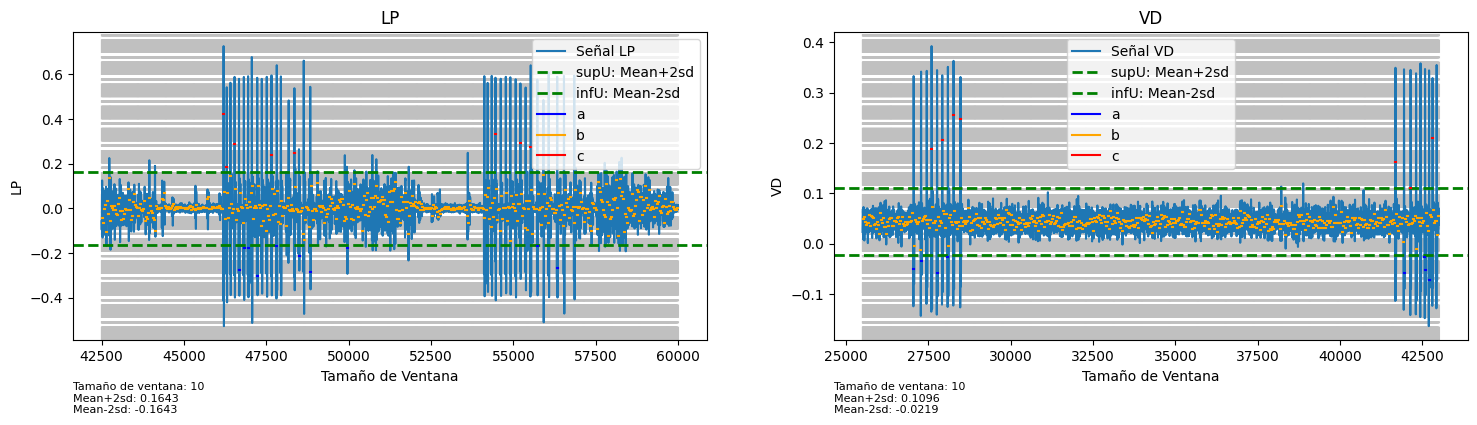

In [22]:
break_size = 10
data_init = 42500
data_end = 60000
data2 = data
data2 = data2.iloc[data_init:data_end]
breaks = np.arange(data_init,data_end,break_size)
data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]

d = data2.groupby('breaks')[['LP','VD']].agg('mean').reset_index()
d['min_x'] = d['breaks']
d['amx_x'] = d['breaks'] + break_size

plt.subplot(1,2,1)
for i in breaks[breaks<=data_end]:
    plt.axvline(x=i, color = 'silver', linestyle = '-.')

plt.plot(data2.Time, data2.LP, label = 'Señal LP')
plt.axhline(y = high_lp, color='g', linestyle='--', linewidth=2, label = 'supU: Mean+'+ str(dist_sd) +'sd')
plt.axhline(y = low_lp, color='g', linestyle='--', linewidth=2, label = 'infU: Mean-'+ str(dist_sd) +'sd')
plt.title('LP')
plt.xlabel('Tamaño de Ventana')
plt.ylabel('LP')
plt.legend()
plt.annotate('Tamaño de ventana: '+ str(break_size) + '\nMean+'+ str(dist_sd) +'sd: '+ str(round(high_lp,4)) + '\nMean-'+ str(dist_sd) +'sd: '+ str(round(low_lp,4)), (0,0), (0,-30), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

for i in range(len(d)):
    c = None
    if d.iloc[i,1] < low_lp:
        c = 'blue'
    elif d.iloc[i,1] >= low_lp and d.iloc[i,1] <= high_lp:
        c = 'orange'
    else:
        c = 'red'
    plt.plot([d.iloc[i,3],d.iloc[i,4]],[d.iloc[i,1], d.iloc[i,1]], color = c)

a = Line2D([0], [0], label='a', color='blue')
b = Line2D([0], [0], label='b', color='orange')
c = Line2D([0], [0], label='c', color='red')

handles, labels = plt.gca().get_legend_handles_labels()
#add handles
handles.extend([a,b,c])

#add legend
plt.legend(handles=handles)


break_size = 10
data_init = 25500
data_end = 43000

data2 = data
data2 = data2.iloc[data_init:data_end]
breaks = np.arange(data_init,data_end,break_size)
data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]

d = data2.groupby('breaks')[['LP','VD']].agg('mean').reset_index()
d['min_x'] = d['breaks']
d['amx_x'] = d['breaks'] + break_size

plt.subplot(1, 2, 2)
for i in breaks[breaks<=data_end]:
    plt.axvline(x=i, color = 'silver', linestyle = '-.')
plt.plot(data2.Time, data2.VD, label = 'Señal VD')
plt.axhline(y = high_vd, color='g', linestyle='--', linewidth=2, label =  'supU: Mean+'+ str(dist_sd) +'sd')
plt.axhline(y = low_vd, color='g', linestyle='--', linewidth=2, label = 'infU: Mean-'+ str(dist_sd) +'sd')
plt.title('VD')
plt.xlabel('Tamaño de Ventana')
plt.ylabel('VD')
plt.legend()
plt.annotate('Tamaño de ventana: '+ str(break_size) + '\nMean+'+ str(dist_sd) +'sd: '+ str(round(high_vd,4)) + '\nMean-'+ str(dist_sd) +'sd: '+ str(round(low_vd,4)), (0,0), (0,-30), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

for i in range(len(d)):
    c = None
    if d.iloc[i,2] < low_vd:
        c = 'blue'
    elif d.iloc[i,2] >= low_vd and d.iloc[i,2] <= high_vd:
        c = 'orange'
    else:
        c = 'red'
    plt.plot([d.iloc[i,3],d.iloc[i,4]],[d.iloc[i,2], d.iloc[i,2]], color = c)

a = Line2D([0], [0], label='a', color='blue')
b = Line2D([0], [0], label='b', color='orange')
c = Line2D([0], [0], label='c', color='red')

handles, labels = plt.gca().get_legend_handles_labels()
#add handles
handles.extend([a,b,c])

#add legend
plt.legend(handles=handles)

# Codificación de SAX

In [23]:
def apply_sax_lp(val):
    if val < low_lp:
        return 'a'
    elif val >= low_lp and val <= high_lp:
        return 'b'
    else:
        return 'c'
    
def apply_sax_vd(val):
    if val < low_vd:
        return 'a'
    elif val >= low_vd and val <= high_vd:
        return 'b'
    else:
        return 'c'

In [24]:
breaks = np.arange(0,len(data),21)
d = data
d.loc[:,'breaks'] = np.repeat(breaks,21)[0:len(d)]
d = d.groupby('breaks')[['LP','VD']].agg('mean').reset_index()
d['CodLP'] = d['LP'].apply(apply_sax_lp)
d['CodVD'] = d['VD'].apply(apply_sax_vd)

In [25]:
window_sizes_w = np.arange(1,60,1)

df_w_MI = []
df_w_MI_norm = []

for win_size in window_sizes_w:
    breaks = np.arange(0,len(data),win_size)
    d = data
    d.loc[:,'breaks'] = np.repeat(breaks,win_size)[0:len(d)]
    d = d.groupby('breaks')[['LP','VD']].agg('mean').reset_index()
    d['CodLP'] = d['LP'].apply(apply_sax_lp)
    d['CodVD'] = d['VD'].apply(apply_sax_vd)

    MI = mutual_info_score(d['CodLP'], d['CodVD'])
    MI_norm = mutual_info_score(d['CodLP'], d['CodVD'])/win_size

    df_w_MI.append(MI)    
    df_w_MI_norm.append(MI_norm)



# Visualización de la Información Mutua Normalizada

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


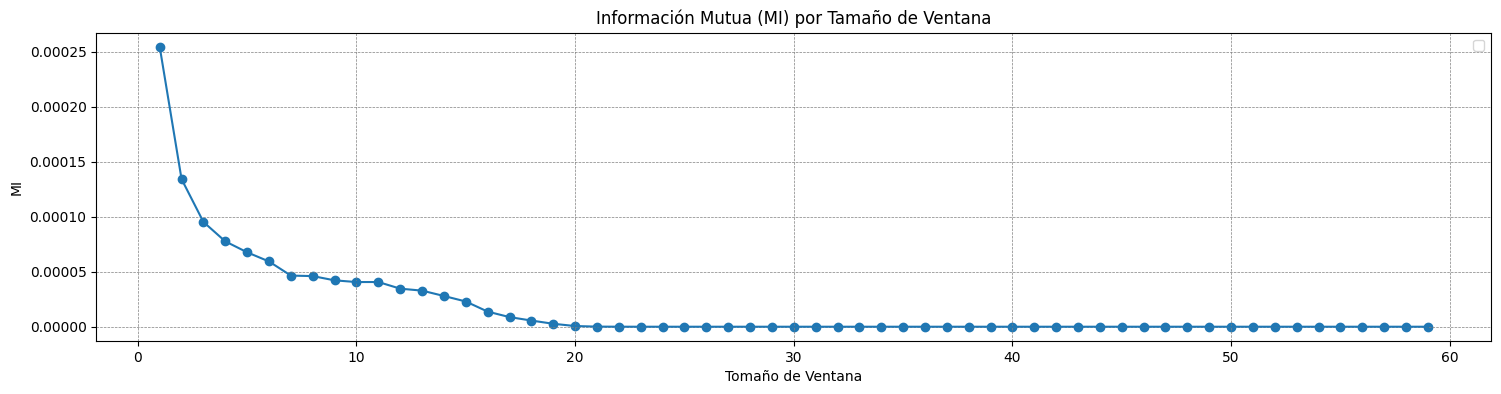

In [26]:
plt.scatter(window_sizes_w, df_w_MI_norm)
plt.plot(window_sizes_w, df_w_MI_norm)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('Información Mutua (MI) por Tamaño de Ventana')
plt.xlabel('Tomaño de Ventana')
plt.ylabel('MI')
plt.legend()

# Codificación SAX LP vs VD

C:\Users\marlo\AppData\Local\Temp\ipykernel_14212\2625203363.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]
C:\Users\marlo\AppData\Local\Temp\ipykernel_14212\2625203363.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no 

C:\Users\marlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\marlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


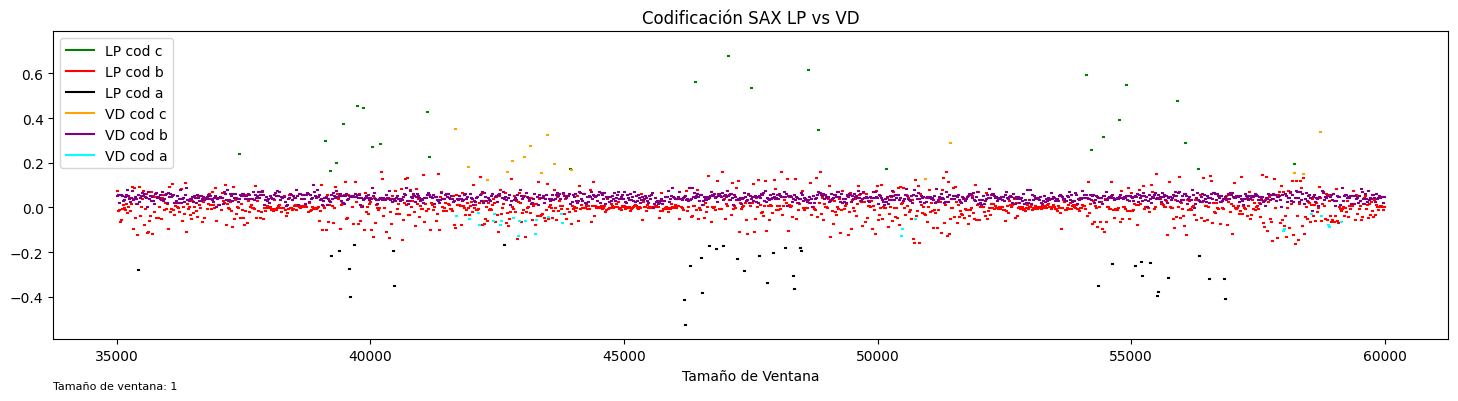

In [27]:
break_size = 1
data_init = 35000
data_end = 60000
data2 = data
data2 = data2.iloc[data_init:data_end]
breaks = np.arange(data_init,data_end,break_size)
data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]

d2 = data2.groupby('breaks')[['LP','VD']].agg('mean').reset_index()
d2['min_x'] = d2['breaks']
d2['amx_x'] = d2['breaks'] + break_size


for i in range(len(d2)):
    c = None
    if d2.iloc[i,1] < low_lp:
        c = 'black'
    elif d2.iloc[i,1] >= low_lp and d2.iloc[i,1] <= high_lp:
        c = 'red' #'red'
    else:
        c = 'green'
    plt.plot([d2.iloc[i,3],d2.iloc[i,4]],[d2.iloc[i,1], d2.iloc[i,1]], color = c)

a1 = Line2D([0], [0], label='LP cod c', color='green')
a2 = Line2D([0], [0], label='LP cod b', color='red')
a3 = Line2D([0], [0], label='LP cod a', color='black')

data2 = data
data2 = data2.iloc[data_init:data_end]
breaks = np.arange(data_init,data_end,break_size)
data2['breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]

d = data2.groupby('breaks')[['LP','VD']].agg('mean').reset_index()
d['min_x'] = d['breaks']
d['amx_x'] = d['breaks'] + break_size

plt.title('Codificación SAX LP vs VD')
plt.xlabel('Tamaño de Ventana')

plt.legend()
plt.annotate('Tamaño de ventana: '+ str(break_size), (0,0), (0,-30), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

for i in range(len(d)):
    c = None
    if d.iloc[i,2] < low_vd:
        c = 'cyan'
    elif d.iloc[i,2] >= low_vd and d.iloc[i,2] <= high_vd:
        c = 'purple'#'purple'
    else:
        c = 'orange'
    plt.plot([d.iloc[i,3],d.iloc[i,4]],[d.iloc[i,2], d.iloc[i,2]], color = c)


b1 = Line2D([0], [0], label='VD cod c', color='orange')
b2 = Line2D([0], [0], label='VD cod b', color='purple')
b3 = Line2D([0], [0], label='VD cod a', color='cyan')

handles, labels = plt.gca().get_legend_handles_labels()
#add handles
handles.extend([a1,a2,a3,b1,b2,b3])

#add legend
plt.legend(handles=handles)